# Smooth contours
Create smooth contours, create a Shapefile, and zip it for uploading to mapping platforms.

In [27]:
############### Modules and Functions :: DO NOT EDIT ###############

# Import ArcGIS package
import arcpy
# Subprocess allows us to issue commands on the command line
import subprocess
# Zip utlity to extract files
from zipfile import ZipFile
# zip up a directory
import shutil

# Allow overwriting of existing data
arcpy.env.overwriteOutput = True

############### Utility functions ###############

def setWork():
    """Create dictionary of path names from global variables 
    and return dot.notation access to dictionary attributes.
    Used internally for shorthand access to path names."""
    class dotdict(dict):
        """dot.notation"""
        __getattr__ = dict.get
        __setattr__ = dict.__setitem__
        __delattr__ = dict.__delitem__
    p = {
        "project": f'{root}\\{folder}',
        "db": f'{root}\\{folder}\\{folder}.gdb',
        "lidar": f'{root}\\{folder}\\lidar',
        "download": f'{root}\\{folder}\\download',
        "laz": f"{root}\\tools\\LAStools\\bin\\laszip64.exe",
        "lasmerge": f"{root}\\tools\\LAStools\\bin\\lasmerge64.exe",
        "grid":  f"{root}\\tools\\grids\\Phase1.gdb\\KY_5k_LAZ",
        "lasd": f'{root}\\{folder}\\download\\combined.lasd',
        "lasdaoi": f'{root}\\{folder}\\download\\aoi_e.lasd',
        "aoi": f'{root}\\{folder}\\lidar\\aoi.lasd',
        "bands": 'RED Band_1; GREEN Band_2; BLUE Band_3',
        "img": "ImageServices\\Ky_NAIP_2020_2ft",
        "dsm": f'{root}\\{folder}\\lidar\\dsm.lasd',
    }
    return dotdict(p)

def listContents(root, folder):
    """Function to print contents of a directory and report time when the cell finished processing.
    listContents(root, folder)
    Two arguments:
        root = drive letter and folder for your root GIS space (string)
        folder = path to folder in root (string)
    """
    downloads = f'{root}\\{folder}'
    completed = subprocess.run(f'dir {downloads}', shell=True, stdout=subprocess.PIPE)
    print(completed.stdout.decode('UTF-8'))
    print("Finished processing", datetime.datetime.now())

def checkFolder(name):
    """Function to check folder name against special characters for creating project space.
    checkFolder(name)
    One argument:
        name = name of project folder for this application (string)
    """
    special = "\"\' :;\\.!@#$%^&*()-+?=,<>/"
    if any(letter in special for letter in name):
        print("Whoops! You have a special character in your project's name. \nPlease change project name.")
        return False
    else:
        print(f'Creating your project folder...')
        return True
    
############### Project Functions :: DO NOT EDIT ###############

def setUpProject():
    """Function to create project folder and database in root GIS.
    setUpProject()
    No arguments
    """
    p = setWork()
    if checkFolder(folder):
        subprocess.run(f'mkdir {p.project}', shell=True)
        subprocess.run(f'mkdir {p.project}\\shapefiles', shell=True)
        print(f'Your project has been created in the {p.project} folder')
    # Create project geodatabase
    if arcpy.Exists(p.db):
        print(f'{p.db} exists!')
    else:
        print(f"Creating {p.db}")
        arcpy.CreateFileGDB_management(p.project, folder)
    arcpy.env.workspace = p.db
            
def setAoi(lat, lon, buffer):
    """Function to create area of interest and clip LAZ grid layer 
    to interactively download LAZ files.
    setAoi(lat, lon, buffer)
    Three arguments:
        lat = latitude for center of AOI (number)
        lon = longitude for center of AOI (number)
        buffer = distance, in feet, from center of AOI to include in analysis (number)
    """
    p = setWork()
    ky = arcpy.SpatialReference(3089)
    wgs84 = arcpy.SpatialReference(4326)
    arcpy.env.workspace = p.db
    point = arcpy.Point(lon, lat) 
    ptGeometry = arcpy.PointGeometry(point, wgs84)
    arcpy.env.outputCoordinateSystem = ky
    arcpy.CopyFeatures_management(ptGeometry, "point")
    arcpy.analysis.Buffer("point", "aoi", buffer)
    

In [28]:
############### Global variables :: EDIT for your AOI ###############

# Directory path to your root GIS folder. 
root = "c:\\YodasGIS"

# Project name - creates a folder in your root GIS directory.
folder = "DowntownLex"

# Where is your Area of Interest in Kentucky?
lat = 38.0483593
lon = -84.4965512

# How far in feet from the above point do you want to process the raster data?
buffer = 4000

# Set some variables for different surfaces to use
#
# Bare-earth DEM for entire state
dem = 'https://kyraster.ky.gov/arcgis/rest/services/ElevationServices/Ky_DEM_KYAPED_5FT/ImageServer'
#
# Any custom raster surface model
custom = 'C:\\YodasGIS\\UkyCampus\\UkyCampus.gdb\\above_ground'

# Contour interval in feet.
contour_interval = 2

# Index contour, e.g., which interval should be labeled?
contour_index = 10

# Smoothing factor: number of cells from center to calculate in neighbrhood.
smooth = 6

################ DO NOT EDIT ################ 
# 
# Create names for output layers
#
contour_name = f"contour_{contour_interval}ft"
smoothedSurface = f"smooth_{smooth*10}ft"


Finished


In [29]:
# Set up your project
#
setUpProject()

Creating your project folder...
Your project has been created in the c:\YodasGIS\DowntownLex2 folder
Creating c:\YodasGIS\DowntownLex2\DowntownLex2.gdb


In [30]:
# Set up the AOI
#
setAoi(lat, lon, buffer)
#
# Create a square AOI for your select point
#
# arcpy.management.FeatureEnvelopeToPolygon('aoi', 'square_aoi')

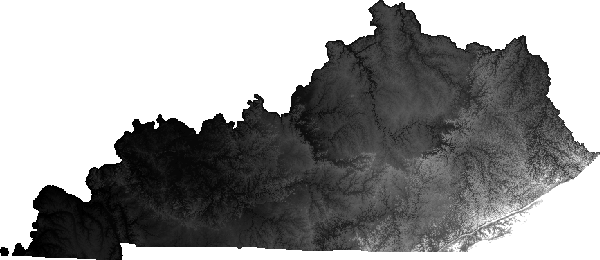

In [31]:
# Load raster
#
a = arcpy.sa.Raster(dem)

# verify
a

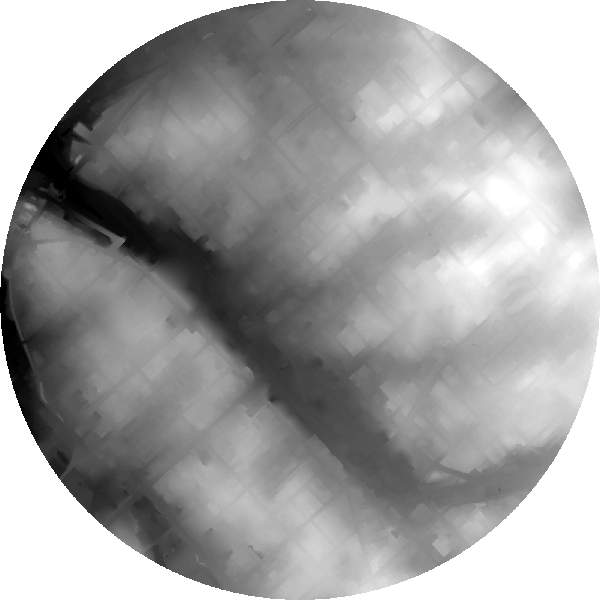

In [32]:
# Extract AOI and save to new layer
#
b = arcpy.sa.ExtractByMask(a, 'aoi')
b.save('original')

#Verify
b

## Focal Statistics

Focal statistics geoprocessing function iterates over the input raster, cell-by-cell, and does statistics on a neighborhood of adjacent cells. It recalculates the input cell with the derived statistic. 

![Example of finding the SUM of cell values in the neighborhood of 1 cell](https://pro.arcgis.com/en/pro-app/latest/tool-reference/spatial-analyst/GUID-A8B2B309-AA73-478F-AFF7-B393CB23B1F7-web.png)    
*Example of finding the SUM of cell values in the neighborhood of 1 adjacent cell*

In our application, we're looking out with a radius set in the `smooth` variable and calculate the mean elevation value for the neighborhood. This calculation will smooth our elevation surface; higher `smooth` values will result in a smoother surface.

Please read the [tool documentation](https://pro.arcgis.com/en/pro-app/latest/tool-reference/spatial-analyst/focal-statistics.htm)

Finished


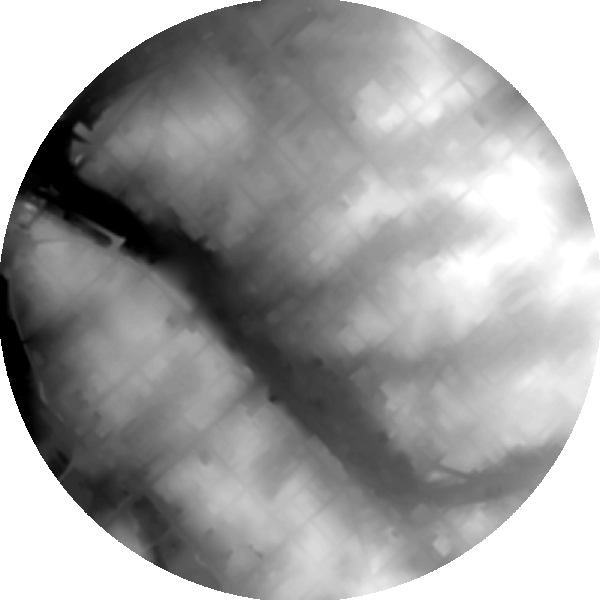

In [33]:
################ DO NOT EDIT ################ 
# 
# Created the smooth elevation model to interpolate elevation contours
#
# Calculate the neighborhood using ArcPy Class NbrCircle(radius, units)
neighborhood = arcpy.sa.NbrCircle(smooth,'CELL')

# Calculate new raster surface uisng ArcPy Geoprocessing function FocalStatistics(in_raster, neighborhood, statistic)
c = arcpy.sa.FocalStatistics('original', neighborhood, "MEAN")

# Print the raster to verify
c

## Contouring

"Contours are lines that connect locations of equal value in a raster dataset that represents continuous phenomena such as elevation, temperature, precipitation, pollution, or atmospheric pressure."

Please read the [tool documentation](https://pro.arcgis.com/en/pro-app/latest/tool-reference/3d-analyst/contour.htm)

In [34]:
################ DO NOT EDIT ################ 
# 
# Created feature class of contour lives fro elevation surface
#
# Function: Contour(in_raster, out_polyline_features, contour_interval)
arcpy.Contour_3d (c, contour_name, contour_interval)

Finished


## Adding attributes for index contour

An index contour is the contour that is symbolized more prominently and labeled on the map. Having an attribute the identifies it as an index makes it easier to symbolize. We'll use the modulo division operator `%` to calculate if an contour is divisible by large whole number without a remainder. E.g., 800 divided by 100 has a remainder of 0, so we could say it's an index contour using an index value of 100.

Tool Documentation
* [Add field](https://pro.arcgis.com/en/pro-app/latest/tool-reference/data-management/add-field.htm)
* [Calculate field](https://pro.arcgis.com/en/pro-app/latest/tool-reference/data-management/calculate-field.htm)

In [35]:
################ DO NOT EDIT ################ 
# 
# Find index contours and label them in a new field
#
y = contour_index

code_block = """
def is_index_contour(x, y):
    if x % y == 0:
        return 1
    else:
        return 0
"""     
arcpy.AddField_management (contour_name, "index", "SHORT")        
arcpy.CalculateField_management(contour_name, "index", f"is_index_contour(!CONTOUR!, {y})", "PYTHON3", code_block)

Finished


In [36]:
################ DO NOT EDIT ################ 
# 
# Convert contours to a Shapefile
#
arcpy.conversion.FeatureClassToShapefile(contour_name, f'{root}\\{folder}\\shapefiles')

Finished


In [37]:
################ DO NOT EDIT ################ 
# 
# Create archive of ShapeFile for upload to web mapping platforms
#
shutil.make_archive(f"{root}\\{folder}\\{contour_name}_{folder}", 'zip',  f'{root}\\{folder}\\shapefiles')

print("Look for a zip file in your project folder. That's what you can upload to Mapbox.")

Finished
